In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [2]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000,)


In [3]:
# number of classes
K = len(set(y_train))
print("number of classes : ",K)

number of classes :  10


In [5]:
# Build the model using the functional API

i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(K, activation='softmax')(x)

model = Model(i,x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1180

In [9]:
# Compile and fit
# Note: make sure you are using hte GPU for this!
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])#실수, 정수 호환때문에 sparse 붙이면됨!
result = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=3 )
result

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 56s 1ms/sample - loss: 0.8808 - accuracy: 0.6926 - val_loss: 0.9437 - val_accuracy: 0.6652
Epoch 2/3
50000/50000 [==============================] - 50s 1ms/sample - loss: 0.7853 - accuracy: 0.7204 - val_loss: 0.8843 - val_accuracy: 0.6900
Epoch 3/3
50000/50000 [==============================] - 51s 1ms/sample - loss: 0.7034 - accuracy: 0.7512 - val_loss: 0.8585 - val_accuracy: 0.7030


In [10]:
# Fit with data augmentation
# Node: if you run this AFTER calling the previous model.fit(), it will CONTINUE training where it left off
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train,y_train,batch_size)


In [16]:
steps_per_epoch = x_train.shape[0] // batch_size # 정수형으로 반환 할땐 // 50000 -> 1562
r = model.fit_generator(train_generator,validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch,epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 1562 steps, validate on 10000 samples
Epoch 1/10
1562/1562 [==============================] - 66s 42ms/step - loss: 0.9950 - accuracy: 0.6504 - val_loss: 0.8303 - val_accuracy: 0.7080
Epoch 2/10
1562/1562 [==============================] - 67s 43ms/step - loss: 0.9417 - accuracy: 0.6712 - val_loss: 0.8428 - val_accuracy: 0.7035
Epoch 3/10
1562/1562 [==============================] - 67s 43ms/step - loss: 0.9172 - accuracy: 0.6767 - val_loss: 0.7937 - val_accuracy: 0.7247
Epoch 4/10
1562/1562 [==============================] - 65s 42ms/step - loss: 0.8834 - accuracy: 0.6895 - val_loss: 0.8027 - val_accuracy: 0.7174
Epoch 5/10
1562/1562 [==============================] - 63s 40ms/step - loss: 0.8578 - accuracy: 0.6985 - val_loss: 0.8287 - val_accuracy: 0.7143
Epoch 6/10
1562/1562 [==============================] - 68s 44ms/step - loss: 0.8374 - accuracy: 0.7076 - val_loss: 0.761

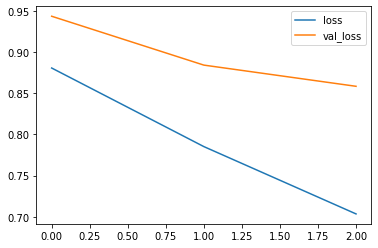

In [11]:
# Plot loss per iteration
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

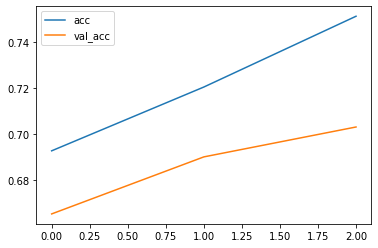

In [12]:
# Plot accuracy per iteration
plt.plot(result.history['accuracy'], label='acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be appled by setting `normalize=True`.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("normalized confusion matrix")
  else:
    print('Consusion matrix, without normalization')
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
# Label mapping


In [ ]:
# Show some misclassified examples


In [ ]:
# Now that the model is so large, it's useful to summarie it
